# Отток клиентов

## Описание проекта

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Есть данные о поведении клиентов и расторжении договоров с банком. 

Метрика: F1-мера.

## Подготовка данных

In [1]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, roc_curve, roc_auc_score)
from sklearn.utils import shuffle
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)

Загрузим данные и осмотрим

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.shape

(10000, 14)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце 'Tenure' есть пропуски

<AxesSubplot:>

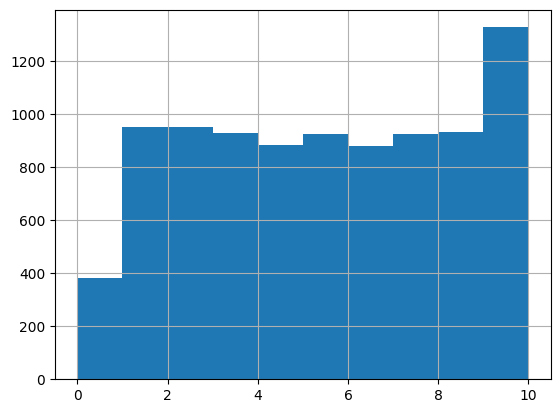

In [6]:
data['Tenure'].hist()

Судя по гистограмме, это просто не введенные по какой-то причине значения

Можно их удалить

In [7]:
data = data.query('not Tenure.isna()')

Проверим данные на наличие явных дубликатов

In [8]:
data.duplicated().sum()

0

Явных дубликатов нет

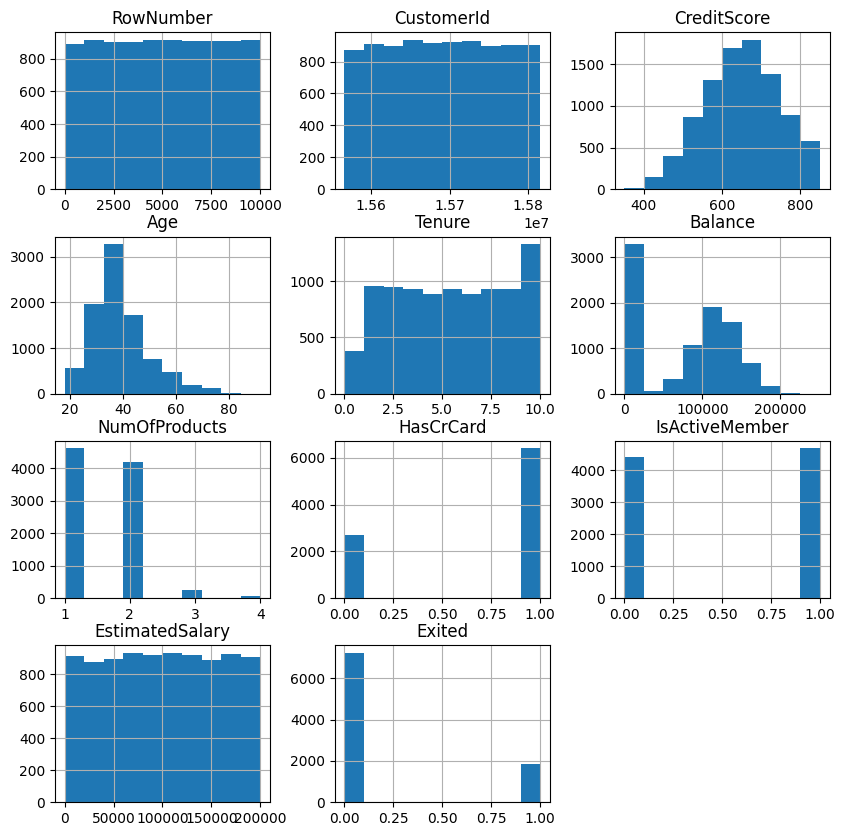

In [9]:
data.hist(figsize=(10, 10));

Есть часть признаков типа object, посмотрим их значения

In [10]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

В базе представлено ограниченное количество стран, значит, стоит их учесть

Фамилии вряд ли являются значимым для обучения модели фактором, поэтому можно их убрать

In [11]:
len(data['Surname'].unique())

2787

In [12]:
len(data['CustomerId'].unique())

9091

In [13]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Уберем лишние столбцы

In [14]:
data = data.drop(['Surname', 'CustomerId', 'RowNumber'] , axis=1)

Итог: часть данных была удалена для более точного обучения, столбцы, явно не влияющие на результат, также были удалены.

## Исследование задачи

Разделим выборку на тренировочную, валидационную и тестовую

In [15]:
rand = 12345

In [16]:
target = data['Exited']
features = data.drop('Exited', axis=1)

In [17]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rand)

In [18]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                                              test_size=0.25, random_state=rand, stratify=target_train)

Переведем категориальные признаки в численные

In [19]:
features_train.loc[features_train['Gender'] == 'Female','Gender'] = 0
features_train.loc[features_train['Gender'] == 'Male','Gender'] = 1
features_valid.loc[features_valid['Gender'] == 'Female','Gender'] = 0
features_valid.loc[features_valid['Gender'] == 'Male','Gender'] = 1
features_test.loc[features_test['Gender'] == 'Female','Gender'] = 0
features_test.loc[features_test['Gender'] == 'Male','Gender'] = 1

C:\Users\dkaga\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [20]:
features_train = features_train.rename(columns={'Gender' : 'Male'})
features_valid = features_valid.rename(columns={'Gender' : 'Male'})
features_test = features_test.rename(columns={'Gender' : 'Male'})

In [21]:
features_train.loc[features_train['Geography'] == 'France','Geography'] = 0
features_train.loc[features_train['Geography'] == 'Spain','Geography'] = 1
features_train.loc[features_train['Geography'] == 'Germany','Geography'] = 2
features_valid.loc[features_valid['Geography'] == 'France','Geography'] = 0
features_valid.loc[features_valid['Geography'] == 'Spain','Geography'] = 1
features_valid.loc[features_valid['Geography'] == 'Germany','Geography'] = 2
features_test.loc[features_test['Geography'] == 'France','Geography'] = 0
features_test.loc[features_test['Geography'] == 'Spain','Geography'] = 1
features_test.loc[features_test['Geography'] == 'Germany','Geography'] = 2

Сделаем масштабирование численных признаков

In [22]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age', 'Tenure']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Посмотрим качество обучения моделей без учета дисбаланса при подборе гиперпараметров моделей

In [23]:
model = LogisticRegression(random_state=rand)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print('Модель: логистическая регрессия, f1', f1)

Модель: логистическая регрессия, f1 0.26804123711340205


0.7448927700586956


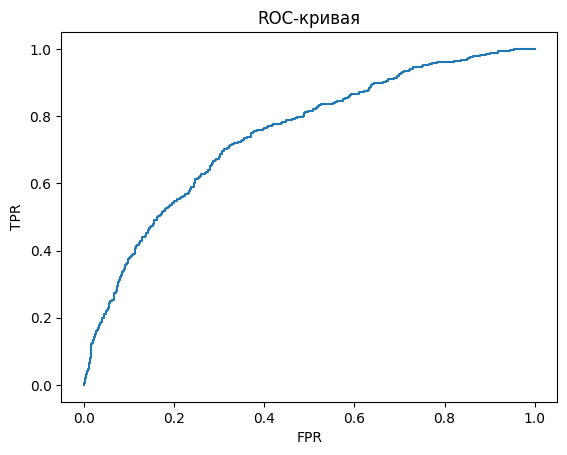

In [24]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [25]:
best_f1 = 0
best_depth = 0
for i in tqdm(range(1,20)):
    time.sleep(1)
    model = DecisionTreeClassifier(random_state=rand, max_depth=i)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = i
print('Модель: решающее дерево')
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 19/19 [00:19<00:00,  1.03s/it]

Модель: решающее дерево
Наиболее подходящая глубина деревьев: 5
f1: 0.5880503144654088


0.823526508046204


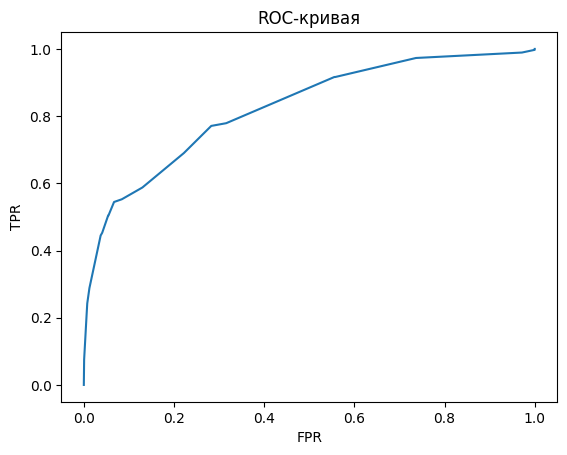

In [26]:
model = DecisionTreeClassifier(random_state=rand, max_depth=5)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [27]:
best_est = 0
best_f1 = 0
best_depth = 0
for i in tqdm(range(100, 600, 100)):
    time.sleep(1)
    for j in range(1,20):
        model = RandomForestClassifier(random_state=12345, n_estimators=i, max_depth=j)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = i
            best_depth = j
print('Наиболее подходящее количество решателей:', best_est)
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 5/5 [02:14<00:00, 27.00s/it]

Наиболее подходящее количество решателей: 500
Наиболее подходящая глубина деревьев: 18
f1: 0.5848739495798319


0.8534080177036978


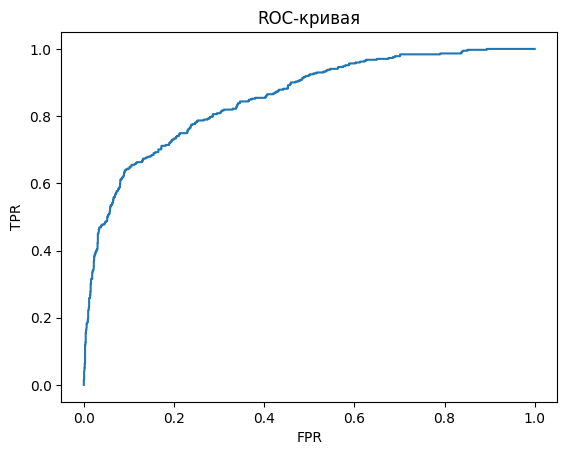

In [28]:
model = RandomForestClassifier(random_state=rand, max_depth=18, n_estimators=500)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

Итог: Среди представленных моделей лучшее значение f1 при подборе гиперпараметров у дерева решений, а значение auc_score - у случайного леса. Качество модели логистической регрессии сильно ниже.

## Борьба с дисбалансом

Имеется очевидный перевес в целевом признаке в сторону отрицательных значений

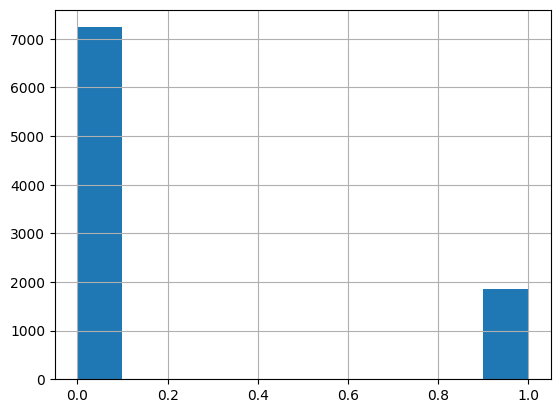

In [29]:
data['Exited'].hist();

Попробуем применить несколько изученных вариантов борьбы с дисбалансом классов: взвешивание классов, уменьшение выборки и увеличение выборки

Сначала проверим модели с учетом взвешивания классов

In [30]:
model = LogisticRegression(random_state=rand, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print('Модель: логистическая регрессия, f1', f1)

Модель: логистическая регрессия, f1 0.48789932236205225


0.7519433273041911


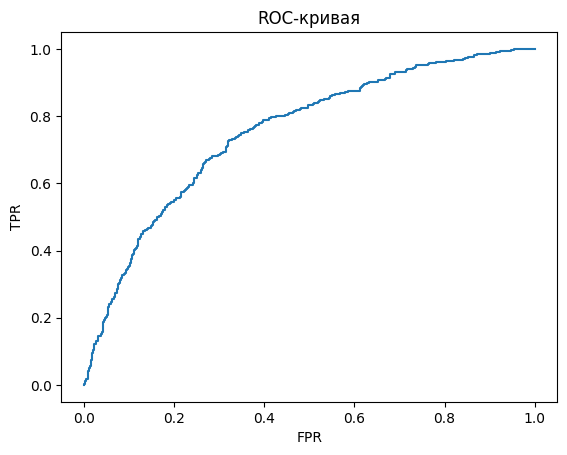

In [31]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [32]:
best_f1 = 0
best_depth = 0
for i in tqdm(range(1,20)):
    time.sleep(1)
    model = DecisionTreeClassifier(random_state=rand, max_depth=i, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = i
print('Модель: решающее дерево')
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 19/19 [00:19<00:00,  1.03s/it]

Модель: решающее дерево
Наиболее подходящая глубина деревьев: 6
f1: 0.5729386892177589


0.8322777677395559


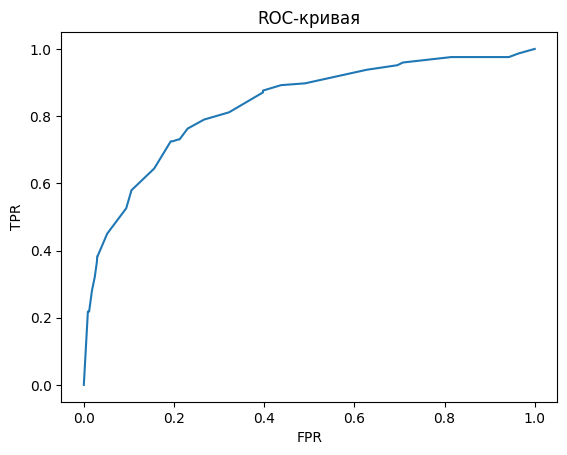

In [33]:
model = DecisionTreeClassifier(random_state=rand, max_depth=6, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [34]:
best_est = 0
best_f1 = 0
best_depth = 0
for i in tqdm(range(100, 600, 100)):
    time.sleep(1)
    for j in range(1,20):
        model = RandomForestClassifier(random_state=rand, n_estimators=i, max_depth=j, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = i
            best_depth = j
print('Наиболее подходящее количество решателей:', best_est)
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 5/5 [02:09<00:00, 25.81s/it]

Наиболее подходящее количество решателей: 400
Наиболее подходящая глубина деревьев: 8
f1: 0.6372795969773298


0.8628149699070667


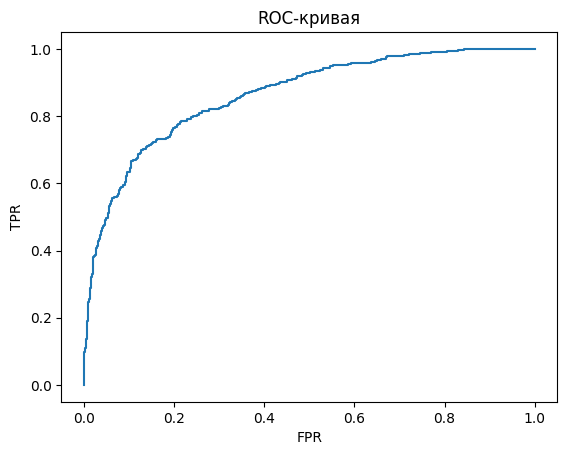

In [35]:
model = RandomForestClassifier(random_state=rand, max_depth=8, n_estimators=100, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

При учете взвешивания классов качество дерева решений понизилось, а логистической регрессии и случайного леса - повысилось. Лучшее качество в данном случае у случайного леса.

Теперь посмотрим влияние увеличения и уменьшения выборки на качество моделей. Отдельно выпишем наши функции для уменьшения и увеличения выборки.

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [37]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим уменьшение выборки

In [38]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Количество отрицательных и положительных значений целевого признака стало близко

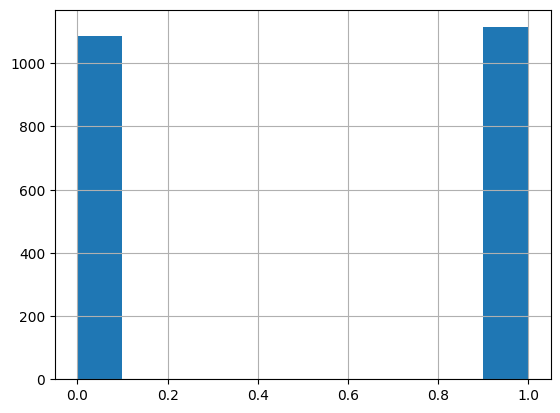

In [39]:
target_downsampled.hist();

In [40]:
model = LogisticRegression(random_state=rand)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print('Модель: логистическая регрессия, f1', f1)

Модель: логистическая регрессия, f1 0.4774688398849473


0.75045870534259


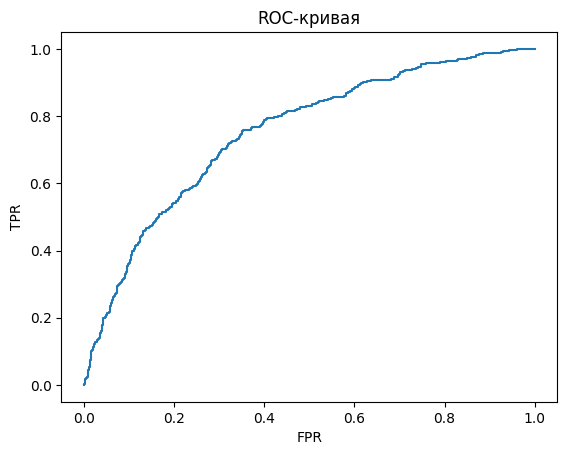

In [41]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [42]:
best_f1 = 0
best_depth = 0
for i in tqdm(range(1,20)):
    time.sleep(1)
    model = DecisionTreeClassifier(random_state=rand, max_depth=i)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = i
print('Модель: решающее дерево')
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 19/19 [00:19<00:00,  1.02s/it]

Модель: решающее дерево
Наиболее подходящая глубина деревьев: 5
f1: 0.576808721506442


0.8376397304954762


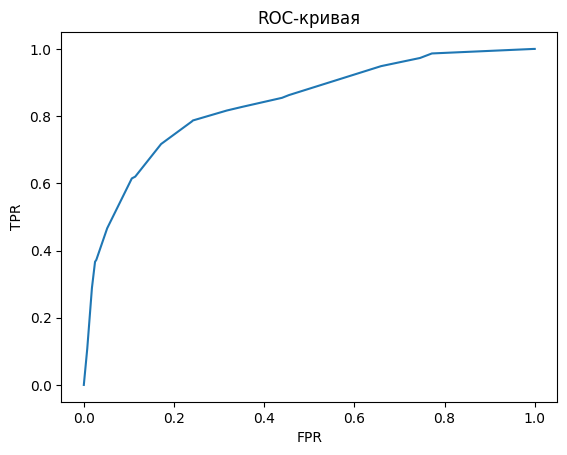

In [43]:
model = DecisionTreeClassifier(random_state=rand, max_depth=5)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [44]:
best_est = 0
best_f1 = 0
best_depth = 0
for i in tqdm(range(100, 600, 100)):
    time.sleep(1)
    for j in range(1,20):
        model = RandomForestClassifier(random_state=rand, n_estimators=i, max_depth=j)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = i
            best_depth = j
print('Наиболее подходящее количество решателей:', best_est)
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 5/5 [01:15<00:00, 15.01s/it]

Наиболее подходящее количество решателей: 400
Наиболее подходящая глубина деревьев: 8
f1: 0.6150537634408603


0.8613880935926548


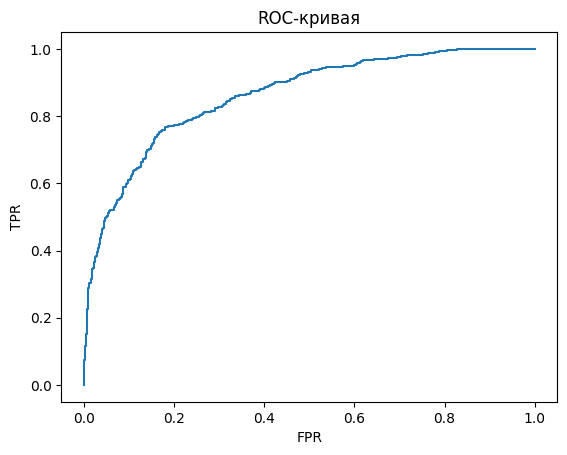

In [45]:
model = RandomForestClassifier(random_state=rand, max_depth=8, n_estimators=400)
model.fit(features_downsampled, target_downsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

При уменьшении выборки отрицательных значений качество дерева решений падает, логистической регрессии и случайного леса - увеличивается. Лучше всего справляется случайный лес, но качество обучения ниже, чем при учете веса.

Применим увеличение выборки

In [46]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Количество отрицательных и положительных значений целевого признака также почти сравнялось

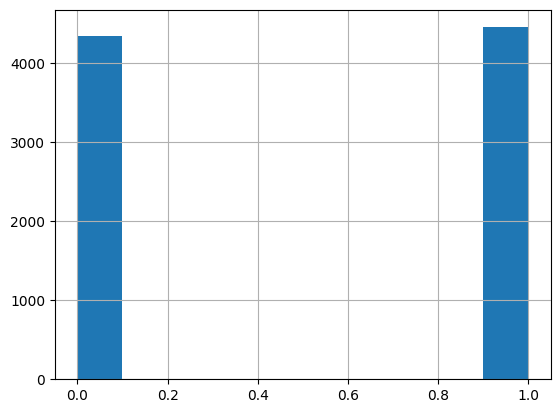

In [47]:
target_upsampled.hist();

In [48]:
model = LogisticRegression(random_state=rand)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print('Модель: логистическая регрессия, f1', f1)

Модель: логистическая регрессия, f1 0.48467432950191575


0.7519936219001299


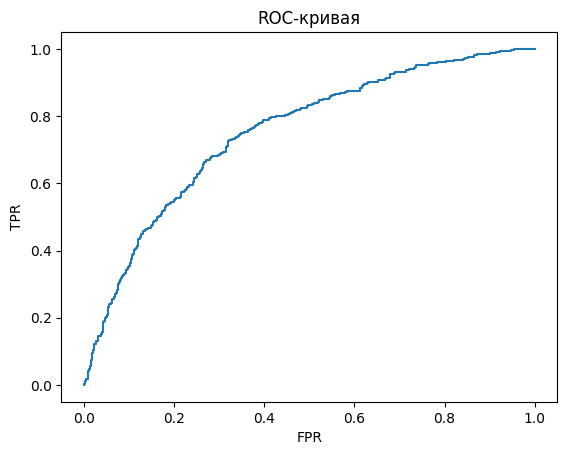

In [49]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [50]:
best_f1 = 0
best_depth = 0
for i in tqdm(range(1,20)):
    time.sleep(1)
    model = DecisionTreeClassifier(random_state=rand, max_depth=i)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = i
print('Модель: решающее дерево')
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 19/19 [00:19<00:00,  1.02s/it]

Модель: решающее дерево
Наиболее подходящая глубина деревьев: 5
f1: 0.576808721506442


0.8376397304954762


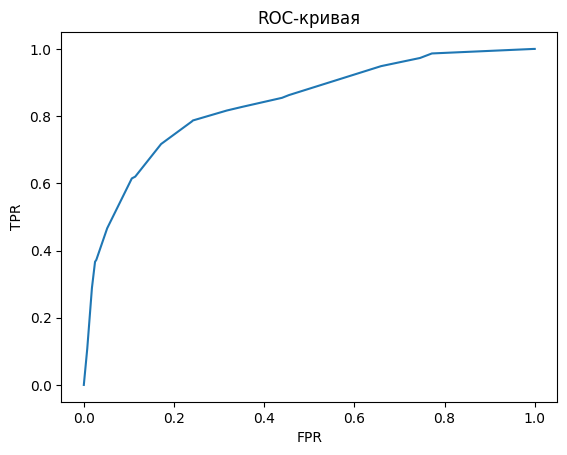

In [51]:
model = DecisionTreeClassifier(random_state=rand, max_depth=5)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

In [52]:
best_est = 0
best_f1 = 0
best_depth = 0
for i in tqdm(range(100, 600, 100)):
    time.sleep(1)
    for j in range(1,20):
        model = RandomForestClassifier(random_state=rand, n_estimators=i, max_depth=j)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = i
            best_depth = j
print('Наиболее подходящее количество решателей:', best_est)
print("Наиболее подходящая глубина деревьев:", best_depth)
print('f1:', best_f1)

100%|██████████| 5/5 [03:07<00:00, 37.50s/it]

Наиболее подходящее количество решателей: 500
Наиболее подходящая глубина деревьев: 13
f1: 0.6428571428571429


0.8557252946425078


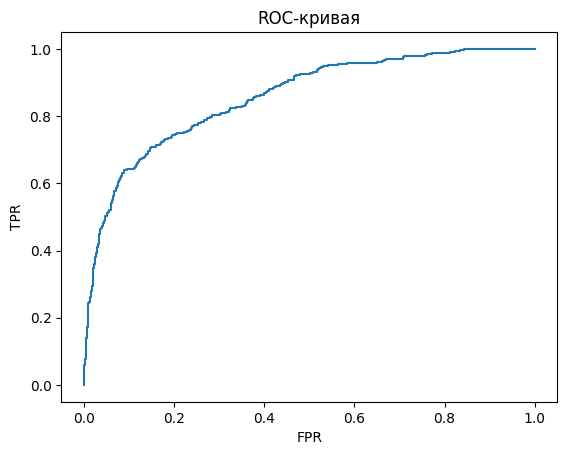

In [53]:
model = RandomForestClassifier(random_state=rand, max_depth=13, n_estimators=500)
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc_roc)

При увеличении выборки положительных целевых значенийкачество решающего дерева падает, логистической регрессии и случайного леа - растет. Лучше всего качество модели случайного леса. Оно превосходит качество при учете веса классов. При этом auc-roc остается ниже, чем при при учете весе классов.

## Тестирование модели

f1 0.5905292479108635
AUC-ROC 0.854961218577703


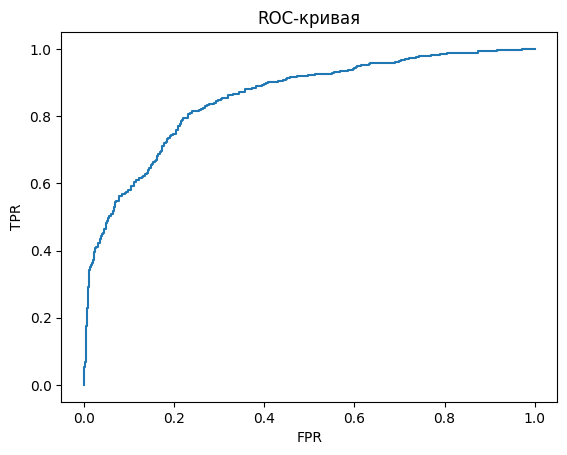

In [54]:
model = RandomForestClassifier(random_state=rand, max_depth=13, n_estimators=500)
model.fit(features_upsampled, target_upsampled)
predictions_test = model.predict(features_test)
f1 = f1_score(target_test, predictions_test)
print('f1', f1)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print('AUC-ROC', auc_roc)

f1 0.6171003717472119
AUC-ROC 0.8653415568638446


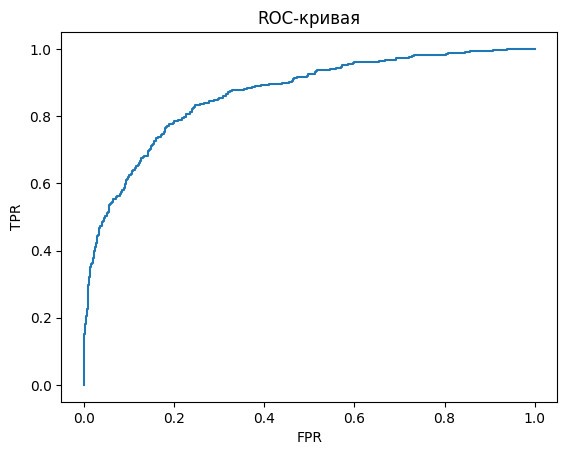

In [55]:
model = RandomForestClassifier(random_state=rand, max_depth=8, n_estimators=100, class_weight='balanced')
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
f1 = f1_score(target_test, predictions_test)
print('f1', f1)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1]) 
ax = plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
print('AUC-ROC', auc_roc)

При проверке на тестовой выборке лучше всего показывает себя модель случайного леса с учетом веса классов

Общий итог: 
- Часть параметров была удалена из датасета за ненадобностью
- На основе оставшихся данных были исследованы модели логистической регрессии, решающего дерева и случайного леса как с учетом дисбаланса классов, так и без
- Учет дисбаланса классов улучшил качество модели случайного леса до преодоления порога f1 в 0.59. Итоговое значение f1 - 0.619 при учете веса классов, без увеличения или уменьшения выборки
- Подобранная модель работает лучше случайной, площадь под ROC-кривой - 0.865 (идеал - 1)